In [24]:
# Import necessary packages
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pylab as plt
import networkx as nx
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
import pyro
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import torch
import numpy as np
import xarray

In [6]:
# Read in the dataset
data = pd.read_csv("../datasets/dag_data_V3.csv")

# Problem Statement
To assess various causes of COVID-19 risk levels across US counties and analyze the effects of conditions and interventions of these causes. This will help suggest appropriate recommendations to individual counties to reduce COVID-19 risk.

Variables under consideration:

| Variable in Dataset 	|                           Explanation                           	|                       Categories (Also Aliases to Conditional Probability Tables)                      	|
|:-------------------:	|:---------------------------------------------------------------:	|:------------------------------------------------------------------------------------------------------:	|
|         CPL         	| Citizen Political Leaning                                       	| Democrat, Even, Heavily Democrat, Heavily Republican, Leaning Democrat, Leaning Republican, Republican 	|
|         SPL         	| State Government Leaning                                        	| Democratic, Republican                                                                                 	|
|         BLG         	| Ban on Large Gatherings                                         	| Expanded Limit, Gatherings Prohibited, Lifted, New Limit on Large Gatherings in Place                  	|
|          UI         	| Urban Influence                                                 	| Metropolitan, Micropolitan, Noncore                                                                    	|
|         ICU         	| Emergency Preparedness (# ICU Beds per 1000 Habitants)          	| High, Low, Medium, Very High                                                                           	|
|          HS         	| Percentage of Population with No High School Degree             	| High, Low, Medium, Very High, Very Low                                                                 	|
|          MI         	| Median Household Income                                         	| High, Low, Medium, Very High, Very Low                                                                 	|
|         CDC         	| CDC Compliance (Percentage of Population who Always Wear Masks) 	| High, Low, Medium                                                                                      	|
|          CC         	| Proportion of Confirmed COVID Cases (Outcome)                            	| High, Low, Medium, Very High, Very Low                                                                 	|

# Construct a DAG model in Pyro to experiment with interventions and conditional modeling

### 1. Construct a DAG using the pgmpy Python package, fit the DAG on the dataset, then   extract conditional probability tables for each variable.

#### Construct a DAG using the pgmpy package.
We will model interventions and inferences on the DAG using the Pyro data science package for Python, but loading the data into a pygmy Bayesian network will allow us to easily transfer large conditional probability tables to Pyro. 

In [41]:
# Create a Bayesian model using pgmpy to represent the DAG.
edges = [('CPL', 'CDC'), ('HS', 'CDC'), ('MI', 'CDC'), ('SPL', 'BLG'),
         ('UI', 'ICU'), ('ICU', 'CC'), ('CDC', 'CC'), ('BLG', 'CC')]

bayes_model = BayesianModel(edges)

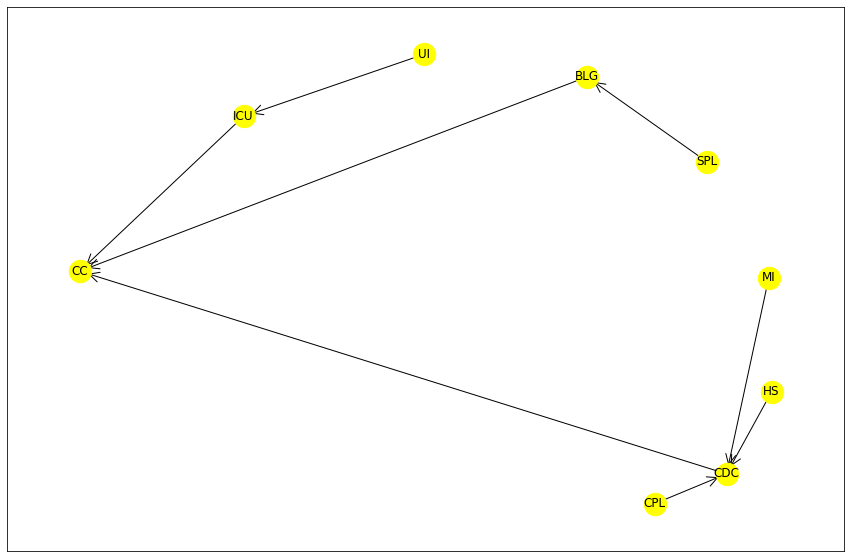

In [120]:
# Plotting of graphical model
G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(15,10))
pos = nx.spiral_layout(G)
nx.draw_networkx_nodes(G, pos, node_color = 'yellow', node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist = edges, arrows = True, arrowsize=25, arrowstyle='->')
plt.show()

#### Fit the model on the cleaned dataset.

In [16]:
# Fit the Bayesian model on the dataset.
bayes_model.fit(data)

#### Extract conditional probability tables for every variable in the DAG.

In [17]:
# Extract labels, probability tables, and a list of incoming variables for each variable in the DAG.
# CPL labels and probabilities
cpl_cpd = bayes_model.get_cpds(node="CPL")
cpl_labels, cpl_proba = cpl_cpd.state_names["CPL"], torch.tensor(cpl_cpd.values.T)

#ICU labels, probabilities, and input variables
icu_cpd = bayes_model.get_cpds(node="ICU")
icu_labels, icu_proba = icu_cpd.state_names["ICU"], torch.tensor(icu_cpd.values.T)
icu_input_vars = icu_cpd.variables

# CDC labels, probabilities, and input variables
cdc_cpd = bayes_model.get_cpds(node="CDC")
cdc_labels, cdc_proba = cdc_cpd.state_names["CDC"], torch.tensor(cdc_cpd.values.T)
cdc_input_vars = cdc_cpd.variables

# HS labels and probabilities
hs_cpd = bayes_model.get_cpds(node="HS")
hs_labels, hs_proba = hs_cpd.state_names["HS"], torch.tensor(hs_cpd.values.T)

# MI labels and probabilities
mi_cpd = bayes_model.get_cpds(node="MI")
mi_labels, mi_proba = mi_cpd.state_names["MI"], torch.tensor(mi_cpd.values.T)

# UI labels and probabilities
ui_cpd = bayes_model.get_cpds(node="UI")
ui_labels, ui_proba = ui_cpd.state_names["UI"], torch.tensor(ui_cpd.values.T)

# SPL labels and probabilities
spl_cpd = bayes_model.get_cpds(node="SPL")
spl_labels, spl_proba = spl_cpd.state_names["SPL"], torch.tensor(spl_cpd.values.T)

# BLG labels, probabilities, and input variables
blg_cpd = bayes_model.get_cpds(node="BLG")
blg_labels, blg_proba = blg_cpd.state_names["BLG"], torch.tensor(blg_cpd.values.T)
blg_input_vars = blg_cpd.variables

# CC labels, probabilities, and input variables
cc_cpd = bayes_model.get_cpds(node="CC")
cc_labels, cc_proba = cc_cpd.state_names["CC"], torch.tensor(cc_cpd.values.T)
cc_input_vars = cc_cpd.variables
# Create a variable storing the County Case rates in proper Likert order for plots
reordered_cc = ["Very Low", "Low", "Medium", "High", "Very High"]

cpl_proba

tensor([0.0266, 0.0522, 0.0565, 0.6575, 0.0431, 0.0673, 0.0969],
       dtype=torch.float64)

### 2. Construct a DAG in Pyro, built upon the conditional probability tables extracted from the pgmpy Bayesian network.

In [18]:
def cc_pyro_model():
    CPL = pyro.sample("CPL", dist.Categorical(probs=cpl_proba)) 
    HS = pyro.sample("HS", dist.Categorical(probs=hs_proba)) 
    MI = pyro.sample("MI", dist.Categorical(probs=mi_proba)) 
    UI = pyro.sample("UI", dist.Categorical(probs=ui_proba))
    SPL = pyro.sample("SPL", dist.Categorical(probs=spl_proba))
    CDC = pyro.sample("CDC", dist.Categorical(probs=cdc_proba[MI][HS][CPL]))
    ICU = pyro.sample("ICU", dist.Categorical(probs=icu_proba[UI]))
    BLG = pyro.sample("BLG", dist.Categorical(probs=blg_proba[SPL]))
    CC = pyro.sample("CC", dist.Categorical(probs=cc_proba[ICU][CDC][BLG]))
    return{"CPL": CPL, "CDC": CDC, "HS" : HS, "MI": MI, "UI": UI,
           "ICU": ICU, "SPL" : SPL, "BLG" : BLG, "CC" : CC} 

print(cc_pyro_model())

{'CPL': tensor(3), 'CDC': tensor(1), 'HS': tensor(1), 'MI': tensor(2), 'UI': tensor(1), 'ICU': tensor(2), 'SPL': tensor(1), 'BLG': tensor(0), 'CC': tensor(3)}


# Validate Testable Implications on the Data

In [19]:
def compute_conditional_prob(model, selected_condition):
    A_posterior = pyro.infer.Importance(model, num_samples=5000).run() 
    A_marginal = EmpiricalMarginal(A_posterior,"CC")
    A_samples = [A_marginal().item() for _ in range(5000)]
    A_unique, A_counts = np.unique(A_samples, return_counts=True)
    samples = [s for s in A_samples if s == selected_condition]
    return len(samples)/len(A_samples)

In [20]:
def get_all_conditional_probs(model, var, var_labels):

    reordered_cc = ["Very Low", "Low", "Medium", "High", "Very High"]
    proba_dict = {}

    # Iterate through each category of the variable
    for i in range(len(var_labels)):
        conditioned_model = pyro.condition(cc_pyro_model, data={var:torch.tensor(i)})
        probability_dict = {}
        
        # Iterate through each covid case rate category
        for j in range(len(cc_labels)):
            probability_dict[cc_labels[j]]= compute_conditional_prob(conditioned_model, j)

        # Format probability findings and insert into dictionary
        proba_dict[var_labels[i]] = {i: probability_dict[i] for i in reordered_cc}
    return proba_dict

In [21]:
def plot_all_conditional_probs(proba_dictionary, ax_dims, fig_dims, plot_name, labels):
    fig, axs = plt.subplots(ax_dims[0], ax_dims[1], figsize=(fig_dims[0], fig_dims[1]))
    fig.suptitle(plot_name + ' vs. COVID Case Rate Probability', fontsize=15)

    category = 0

    for i in range(ax_dims[0]):
        for j in range(ax_dims[1]):
            if category < len(labels):
                axs[i, j].plot(list(proba_dictionary[labels[category]].keys()), 
                       list(proba_dictionary[labels[category]].values()), 
                       label = labels[category])
                axs[i, j].set_title(labels[category])
                category += 1

    for ax in axs.flat:
        ax.set(xlabel='COVID Case Rate Category', ylabel='Probability')
    plt.subplots_adjust(wspace=0.4, hspace = 0.4)
    plt.show()

### Hypothesis 1. Conditioning the DAG on ICU bed availability differentiates COVID-19 case rate outcomes, where counties with fewer ICU beds report higher case rates.

In [22]:
icu_hypothesis_dict = get_all_conditional_probs(cc_pyro_model, 'ICU', icu_labels)
for category in icu_hypothesis_dict:
    print("COVID case rate probabilities for " + category + " ICU bed availability category: ", 
          icu_hypothesis_dict[category], "\n")

COVID case rate probabilities for High ICU bed availability category:  {'Very Low': 0.1992, 'Low': 0.1744, 'Medium': 0.2042, 'High': 0.234, 'Very High': 0.1878} 

COVID case rate probabilities for Low ICU bed availability category:  {'Very Low': 0.215, 'Low': 0.207, 'Medium': 0.2008, 'High': 0.1644, 'Very High': 0.2004} 

COVID case rate probabilities for Medium ICU bed availability category:  {'Very Low': 0.1616, 'Low': 0.137, 'Medium': 0.2264, 'High': 0.1966, 'Very High': 0.2452} 

COVID case rate probabilities for Very High ICU bed availability category:  {'Very Low': 0.1954, 'Low': 0.1636, 'Medium': 0.1614, 'High': 0.2762, 'Very High': 0.2124} 



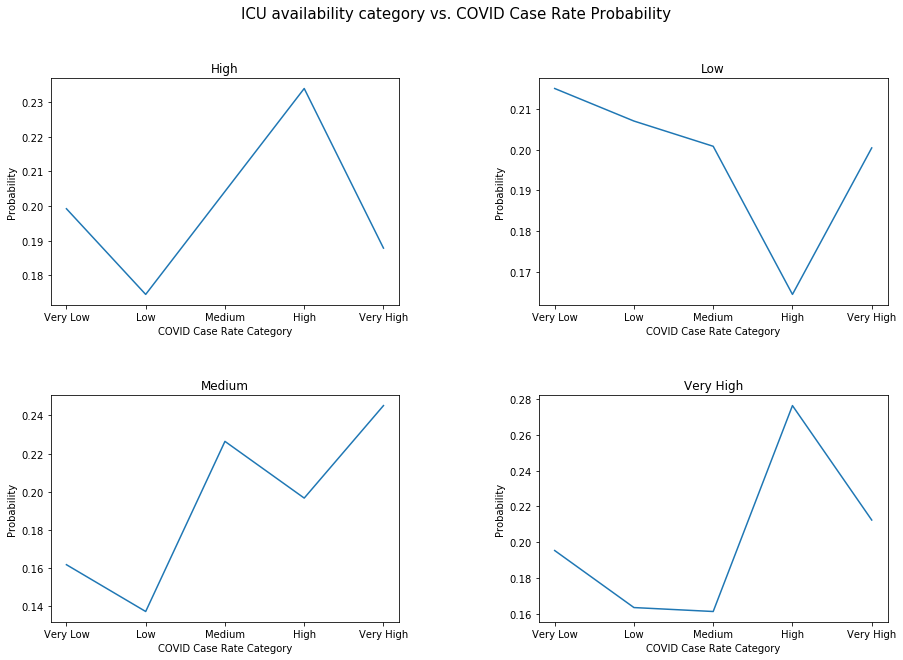

In [23]:
plot_all_conditional_probs(icu_hypothesis_dict, ax_dims=[2, 2], fig_dims=[15, 10], 
                           plot_name="ICU availability category", labels=icu_labels)

### Hypothesis 2. Conditioning the DAG on a county's bans on large gatherings  differentiates counties' COVID-19 case rate outcomes, where counties with stricter bans report lower case rates.

In [12]:
blg_hypothesis_dict = get_all_conditional_probs(cc_pyro_model, 'BLG', blg_labels)
for category in blg_hypothesis_dict:
    print("COVID case rate probabilities for " + category + " large gathering ban category: ", 
          blg_hypothesis_dict[category], "\n")

COVID case rate probabilities for >10 People Prohibited large gathering ban category:  {'Very Low': 0.2864, 'Low': 0.3028, 'Medium': 0.2168, 'High': 0.1042, 'Very High': 0.1112} 

COVID case rate probabilities for All Gatherings Prohibited large gathering ban category:  {'Very Low': 0.3568, 'Low': 0.307, 'Medium': 0.1264, 'High': 0.1274, 'Very High': 0.0848} 

COVID case rate probabilities for Expanded Limit to 25 or Fewer large gathering ban category:  {'Very Low': 0.5406, 'Low': 0.2974, 'Medium': 0.1124, 'High': 0.0104, 'Very High': 0.018} 

COVID case rate probabilities for Expanded Limit to Greater Than 25 large gathering ban category:  {'Very Low': 0.2014, 'Low': 0.1726, 'Medium': 0.1736, 'High': 0.225, 'Very High': 0.2364} 

COVID case rate probabilities for Lifted large gathering ban category:  {'Very Low': 0.076, 'Low': 0.157, 'Medium': 0.2138, 'High': 0.26, 'Very High': 0.2696} 

COVID case rate probabilities for New Limit on Large Gatherings in Place large gathering ban categ

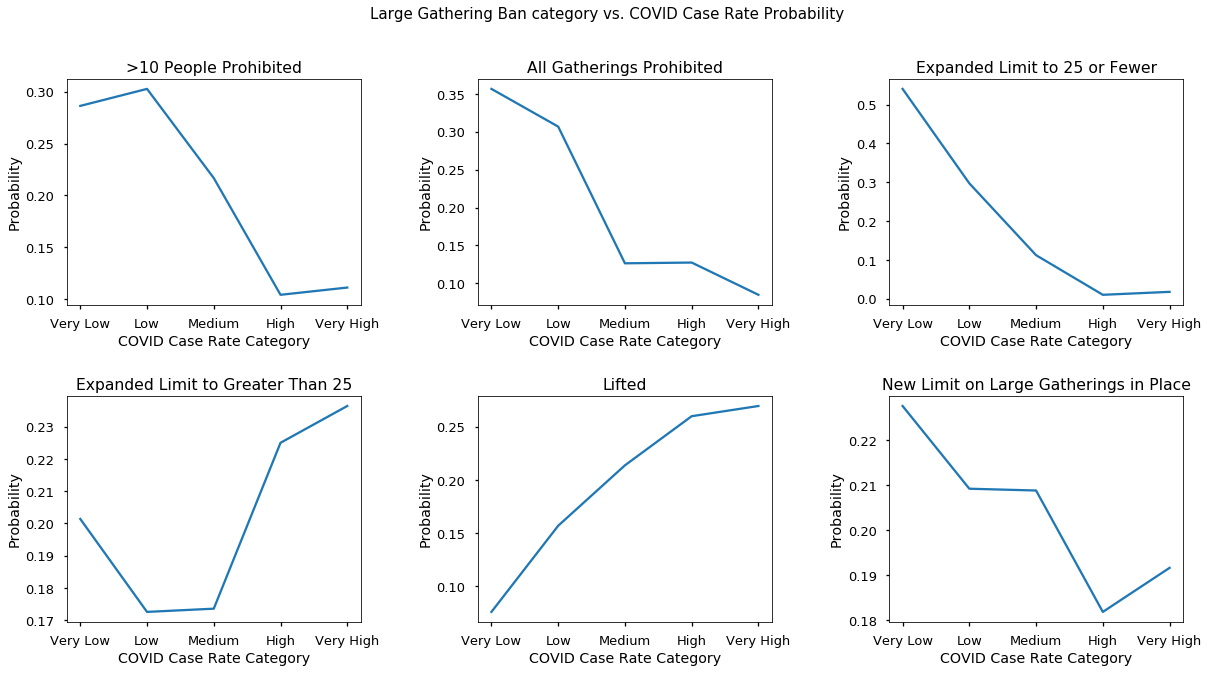

In [42]:
plot_all_conditional_probs(blg_hypothesis_dict, ax_dims=[2, 3], fig_dims=[20, 10], 
                           plot_name="Large Gathering Ban category", labels=blg_labels)

### Hypothesis 3. Conditioning the DAG on citizen CDC compliance  differentiates counties' COVID-19 case rate outcomes, where counties with greater compliance report lower case rates.

In [14]:
cdc_hypothesis_dict = get_all_conditional_probs(cc_pyro_model, 'CDC', cdc_labels)
for category in cdc_hypothesis_dict:
    print("COVID case rate probabilities for " + category + " CDC compliance category: ", 
          cdc_hypothesis_dict[category], "\n")

COVID case rate probabilities for AlwaysWearMasks CDC compliance category:  {'Very Low': 0.2168, 'Low': 0.1954, 'Medium': 0.1888, 'High': 0.194, 'Very High': 0.1868} 

COVID case rate probabilities for FrequentlyWearMasks CDC compliance category:  {'Very Low': 0.153, 'Low': 0.2056, 'Medium': 0.1852, 'High': 0.1668, 'Very High': 0.3206} 

COVID case rate probabilities for NeverWearMasks CDC compliance category:  {'Very Low': 0.107, 'Low': 0.088, 'Medium': 0.1974, 'High': 0.2582, 'Very High': 0.3566} 

COVID case rate probabilities for RarelyWearMasks CDC compliance category:  {'Very Low': 0.1232, 'Low': 0.165, 'Medium': 0.1452, 'High': 0.3458, 'Very High': 0.2228} 

COVID case rate probabilities for SometimesWearMasks CDC compliance category:  {'Very Low': 0.1098, 'Low': 0.1988, 'Medium': 0.344, 'High': 0.1172, 'Very High': 0.2856} 



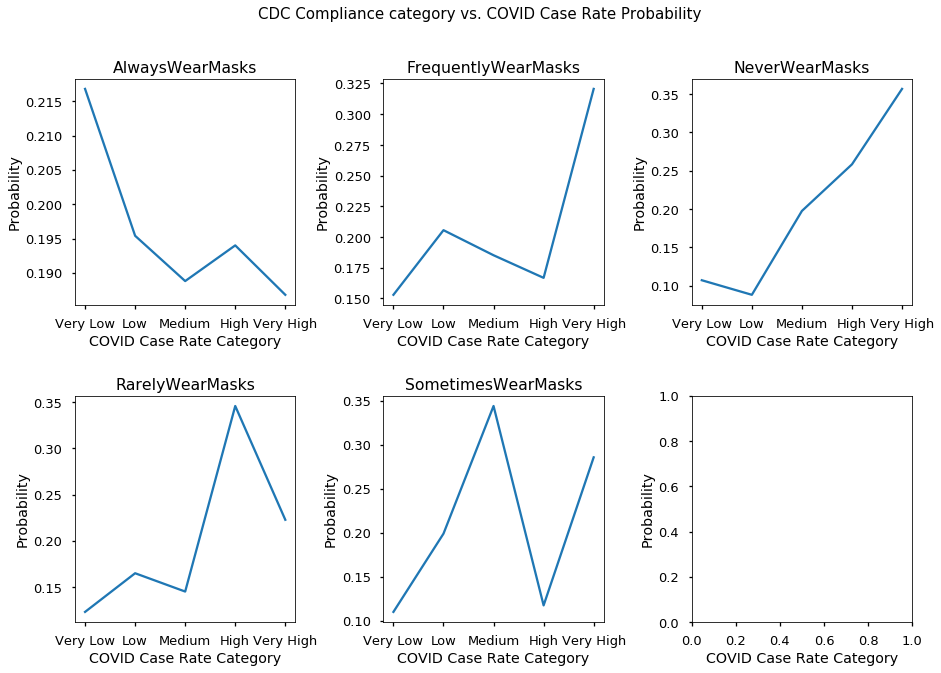

In [41]:
plot_all_conditional_probs(cdc_hypothesis_dict, ax_dims=[2, 3], fig_dims=[15, 10], 
                           plot_name="CDC Compliance category", labels=cdc_labels)

# Show evidence of parametric assumptions using a posterior predictive check:

## TODO: Fill this out with models to check, and format into some nice plots


# Use do-interventions to assess the causal effects of interest: